In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import polyan

#define a reference profile based on a representative polysome experimental profile
ref_peaks = [0.003, 0.0051, 0.026, 0.018, 0.0205, 0.0155, 0.012, 0.0085, 0.008, 0.006, 0.005, 0.0035, 0.002, 0.0015, 0.001, 0.0005, 0.0002, 5e-05]
ref_peaks = ref_peaks/ np.sum(ref_peaks)
x_ref,y_ref = polyan.plot_poly(ref_peaks)

In [2]:
#prepare datasets by combining nrmsd and cluster info with the context data
yeast_datasets = pd.read_csv('Data/yeast_datasets.csv')[['SeriesID','nrmsd','re_cluster']]
yeast_datasets.columns = ['dataset','nrmsd','re_cluster']
context_dataset = pd.read_csv('Data/yeast_dataset_context.csv')
regression_dataset = yeast_datasets.merge(context_dataset,on='dataset',how='inner')#define which of the context features to use
selected_features = ['max_periodicity','number_of_reads','5_KL','3_KL','A_site_KL','Lowest_median_base_qual','Peak_per_sequence_quality','Highest_overrepresented_sequence_frequency']
#define the subset of Datasets that cluster separately with the ref RNA dataset
exceptions = ['GSE56622','GSE100626','GSE108778','GSE115366','GSE121189']

In [3]:
#calculate the test statistics for comparisons between the "exception" and other datasets for each feature
#independent ttests with multi-sample correction (holm-sidak)
uncorrected_p = []
for feature in selected_features:
    main_set,exception_set = [],[]
    for row in range(regression_dataset.shape[0]):
        if regression_dataset['dataset'].iloc[row] in exceptions:
            exception_set.append(regression_dataset[feature].iloc[row])
        else:
            main_set.append(regression_dataset[feature].iloc[row])
    uncorrected_p.append(ttest_ind(main_set,exception_set)[1])
corrected_p = list(multipletests(uncorrected_p)[1])

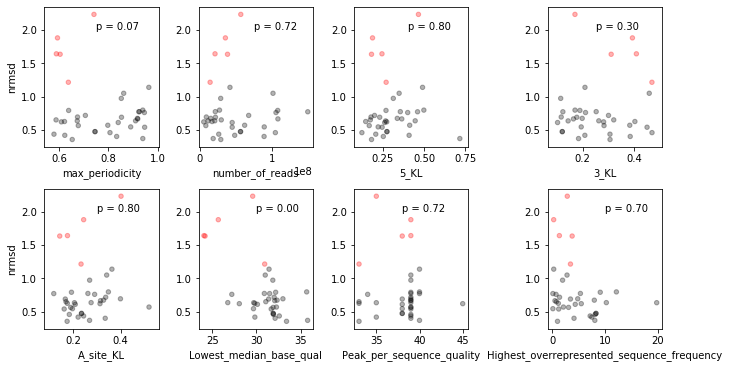

In [4]:
y_plot = regression_dataset['nrmsd']
fig,ax = plt.subplots(2,int(len(selected_features)/2),figsize=(10,5),constrained_layout=True)
label_pos = [0.75,75000000,0.4,0.25,0.3,30,38,10]
#prepare a color list to display datasets that still have high nrmsd when used with ref RNA set in red
cols = []
for dataset in regression_dataset['dataset']:
    if dataset in exceptions:
        cols.append('red')
    else:
        cols.append('black')
for feature_no in range(len(selected_features)):
    if feature_no < 4:
        row = 0
        col = feature_no
    else:
        row = 1
        col = feature_no - 4
    ax[row,col].scatter(regression_dataset[selected_features[feature_no]],y_plot,s=20,c=cols,alpha = 0.3)
    ax[row,col].set_xlabel(selected_features[feature_no])
    ax[row,col].text(label_pos[feature_no],2,'p = {:.2f}'.format(corrected_p[feature_no]))
ax[0,0].set_ylabel('nrmsd')
ax[1,0].set_ylabel('nrmsd')
#plt.savefig('Correlations.svg')
plt.show()

In [5]:
X = regression_dataset[selected_features]
y_tree = regression_dataset['re_cluster']

#construct and apply a pipeline that scales the data and fits the Extra Trees Classifier
scaler = StandardScaler()
clf = ExtraTreesClassifier(n_estimators=100,random_state=24)
cat_pipeline = make_pipeline(scaler, clf)
cat_pipeline.fit(X,y_tree)

coefs = abs(clf.feature_importances_) / sum(clf.feature_importances_  )

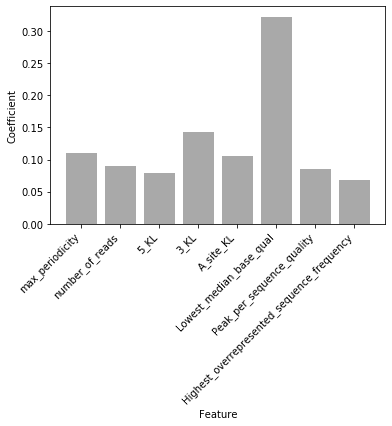

In [6]:
fig,ax = plt.subplots()
ax.bar(x=selected_features,height=coefs,color = 'darkgrey')
ax.set_ylabel('Coefficient')
ax.set_xlabel('Feature')
ax.set_xticklabels(selected_features,rotation=45,horizontalalignment="right")
#plt.savefig('Pred_Coeffs.svg')
plt.show()

<a name="CHX"></a>
<h2>Cycloheximide Series</h2>
<p>This analyses data generated by <a href="https://www.ncbi.nlm.nih.gov/pubmed/25056308" target=_blank>Gerashchenko and Gladyshev (2014)</a> using a cycloheximide concentration series. The dataset is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59573" target=_Blank>GSE59573</a>. "1x CHX" refers to the standard final concentration of 100 &mu;g/ml.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [7]:
#read in the CHX concentration series data and produce the peak information
poly_vols = []
all_dats = pd.read_csv('Data/GSE59573_all_CHX_concs.csv')
for col in range(1,all_dats.shape[1]):
    dats = all_dats.iloc[:,[0,col]]
    dats.columns = ['ORF','Ribo_Prints']
    poly_vols.append(polyan.fp2poly(dats, has_RNA = False))

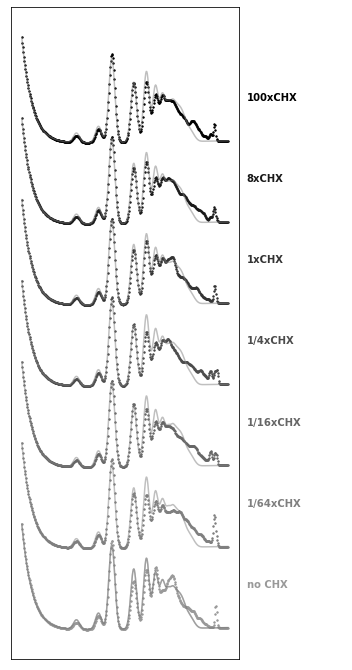

In [8]:
#plot the results
labels = list(all_dats.columns[1:])
labels = [l.replace('_','/') for l in labels]
labels = [l.replace('0/','no ') for l in labels]
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('CHX_series.svg')
plt.show()

<a name="libraries"></a>
<h2>Library preparation protocols</h2>
<p>This analyses data from <a href="https://www.ncbi.nlm.nih.gov/pubmed/27450428" target=_blank>Lecanda <i>et al.</i> (2016).</a> which tests a variety of library preparation protocols. The dataset used is <a href="https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84746" target=_blank>GSE84746</a>.</p>
<p><a href='#TOC'>Back to top.</a></p>

In [9]:
#analysis of library prep series
poly_vols = []
for file in ['GSE84746_DualLigation.csv','GSE84746_3N.csv',
             'GSE84746_4N.csv','GSE84746_4N_low.csv',
             'GSE84746_nonrand.csv','GSE84746_nonrand_low.csv']:
    dats = pd.read_csv('Data/' + file)[['ORF','Ribo_Prints']]
    poly_vols.append(polyan.fp2poly(dats,has_RNA=False))

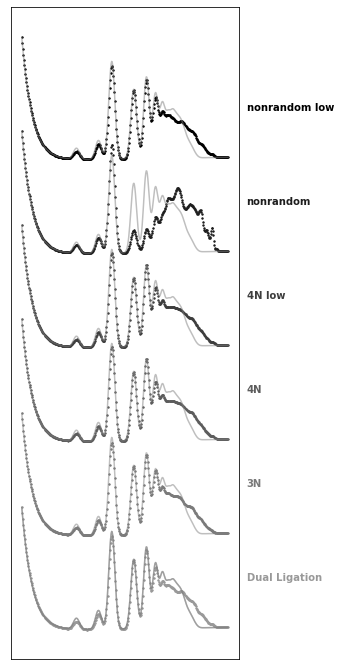

In [10]:
#plot the results
labels = ['Dual Ligation','3N','4N','4N low','nonrandom','nonrandom low']
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('library_series.svg')
plt.show()

<a name="nucleases"></a>
<h2>Nuclease series</h2>
<p>This analyses data from <a href='https://pubmed.ncbi.nlm.nih.gov/27638886/' target=_blank>Gerashchenko and Galdyshev</a> (2017) which compares the use of different nucleases in the preparation of ribosome protected fragments. The dataset used is <a href='https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE82220' target=_blank>GSE82220</a>.
<p><a href='#TOC'>Back to top.</a></p>

In [11]:
#read in the nuclease concentration series data and produce the peak information
poly_vols = []
all_dats = pd.read_csv('Data/GSE82220_all_yeast_data.csv')
#average the two repeats for nuclease I
all_dats['I'] = all_dats[['I.1','I.2']].mean(axis=1)
all_dats = all_dats[['gene','S7','A','T1','I']]
#remove rows summarising reads mapped to multiple genes, 
#which are indicated by gene descriptors like 'gene1_gene2'
all_dats = all_dats[all_dats['gene'].map(lambda x: '_' not in str(x))]
#calculate the peak volumes
for col in range(1,all_dats.shape[1]):
    dats = all_dats.iloc[:,[0,col]]
    dats.columns = ['ORF','Ribo_Prints']
    poly_vols.append(polyan.fp2poly(dats, has_RNA = False))

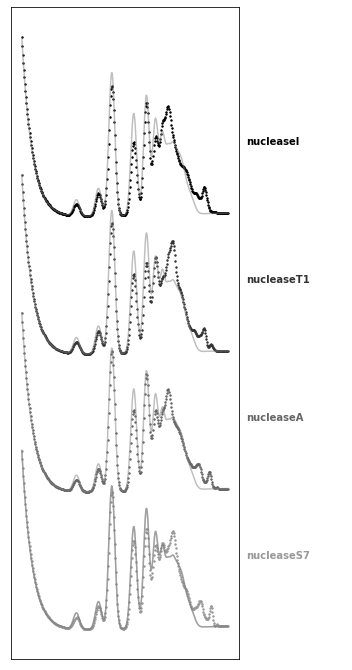

In [12]:
#plot the results
labels = ['nuclease' + nuc for nuc in all_dats.columns[1:]]
#labels = [l.replace('_','/') for l in labels]
#labels = [l.replace('0/','no ') for l in labels]
colors=plt.cm.gist_yarg(np.linspace(0.4,1,len(poly_vols)))
fig,ax = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]},figsize = (6,12))
ax[0].set_prop_cycle(cycler(color=colors))
ax[0].plot(x_ref,y_ref,c='grey', label='experimental',alpha = 0.5)
offset_by = 5
offset = 0
for trace_no in range(len(poly_vols)):    
    ax[0].plot(x_ref,y_ref+offset ,c='grey', label='experimental',alpha = 0.5)    
    x,y = polyan.plot_poly(poly_vols[trace_no])
    ax[0].scatter(x,y+offset,s=2,label = labels[trace_no])
    ax[1].text(-0.3,offset+max(y_ref[20:])/2,labels[trace_no],color = colors[trace_no],
              fontdict={'weight':'bold'})
    offset += offset_by
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[1].axis('off')
#plt.savefig('nuclease_series.svg')
plt.show()